# NIST-MST on Census dataset

Adapted from **WINNING THE NIST CONTEST: A SCALABLE AND GENERAL APPROACH TO DIFFERENTIALLY PRIVATE SYNTHETIC DATA** (https://arxiv.org/pdf/2108.04978.pdf)

Depends on https://github.com/ryan112358/private-pgm.

In [1]:
import itertools

import numpy as np
import pandas as pd
import networkx as nx

import scipy.stats, scipy.optimize

import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from mbi import Dataset, Domain, FactoredInference

import sdnist

In [2]:
private, schema = sdnist.census(public=True)
private = private.sample(100000)
private_bin = sdnist.utils.discretize(private, schema, bins=sdnist.kmarginal.CensusKMarginalScore.BINS)

# Build private-pgm Domain and Dataset objects
attrs = []
shape = []

for col in private_bin:
    if col == "sim_individual_id":
        continue

    attrs.append(col)
    shape.append(private_bin[col].max() + 1)
    
domain = Domain(attrs=attrs, shape=shape)
data = Dataset(private_bin, domain)

private_bin

,PUMA,YEAR,HHWT,GQ,PERWT,SEX,AGE,MARST,RACE,HISPAN,...,WORKEDYR,INCTOT,INCWAGE,INCWELFR,INCINVST,INCEARN,POVERTY,DEPARTS,ARRIVES,sim_individual_id
517534,164,0,8,1,8,1,6,5,0,0,...,3,3,3,1,1,3,7,1,1,1166909
737386,143,3,3,1,3,1,10,3,0,0,...,3,1,1,1,1,1,2,1,1,581009
990959,179,3,6,1,6,1,6,5,1,0,...,3,1,1,1,1,1,4,1,1,570487
189454,17,3,5,1,5,0,4,0,0,0,...,3,15,15,1,1,15,26,76,76,166984
349642,173,5,4,1,4,0,10,0,0,0,...,3,21,1,1,1,21,26,1,1,1008940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278741,90,4,2,1,1,0,8,5,0,0,...,1,4,1,1,1,1,26,1,1,1270662
595636,84,1,3,1,3,1,9,0,0,0,...,1,1,1,1,1,1,15,1,1,625537
262882,129,4,6,1,7,0,6,0,0,0,...,3,21,21,1,1,21,26,29,29,891652
1031190,46,6,11,1,11,1,4,0,6,1,...,3,7,7,1,1,7,16,39,41,1223988


In [3]:
# Calibrate noise to add to each marginal
logsf = scipy.stats.norm.logsf

def delta_eps_normal(eps, mu):
    a = logsf(eps/mu - mu*.5)
    b = eps + logsf(eps/mu + mu*.5)

    return np.exp(b) * (np.expm1(a - b))

eps, delta = 1, 2.5e-5
C = 7 # maximum contribution of each individual

mu = scipy.optimize.bisect(lambda m: delta_eps_normal(eps, m) - delta, a=1e-5, b=2)
sigma = np.sqrt((2 * len(attrs) - 1) * C / mu) 
print(sigma)

41.23660003602558


In [4]:
# Step 1 : measure all rank-1 marginals
measurements_1 = []

for col in attrs:
    y = data.project([col]).datavector()
    y += np.random.normal(scale=sigma, size=y.size)
    
    measurements_1.append((np.eye(y.size), y, sigma, (col,)))
    
engine = FactoredInference(domain, log=True)
model = engine.estimate(measurements_1, engine="MD")

Total clique size: 682
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		83306.88		31352539.74		0.00
50.00		0.60		3136.26		13505.00		0.00
100.00		1.34		947.89		1260.56		0.00
150.00		2.07		531.24		446.09		0.00
200.00		2.80		373.46		236.39		0.00
250.00		3.53		293.89		153.36		0.00
300.00		4.27		246.46		110.69		0.00
350.00		5.00		217.41		86.79		0.00
400.00		5.71		197.77		71.83		0.00
450.00		6.43		183.67		61.61		0.00
500.00		7.15		172.87		54.46		0.00
550.00		7.88		164.41		49.23		0.00
600.00		8.61		157.58		45.29		0.00
650.00		9.33		151.96		42.24		0.00
700.00		10.09		147.30		39.77		0.00
750.00		10.81		143.25		37.81		0.00
800.00		11.57		139.77		36.21		0.00
850.00		12.27		136.81		34.90		0.00
900.00		13.02		134.23		33.79		0.00
950.00		13.75		132.02		32.85		0.00


In [5]:
q = {}

total = int(len(attrs) * (len(attrs) - 1) * .5)
for i, j in tqdm(itertools.combinations(attrs, r=2), total=total):
    q[i, j] = np.abs(data.project([i, j]).datavector() - model.project([i, j]).datavector()).sum()

  0%|          | 0/595 [00:00<?, ?it/s]

In [6]:
graph = nx.Graph()
graph.add_nodes_from(attrs)

# Compute noise scale (using naive composition for simplicity)
eps = 0.05
r = len(attrs) - 1
noise_scale = .5 / (eps) * r
print(noise_scale)

for _ in range(len(attrs)-1):
    # Compute set of disconnected attrs
    # The whole algorithm is probably equivalent to a DP-Maximum spanning tree (?)
    S = {(i,j): q[i,j] + np.random.gumbel(scale=noise_scale) for (i, j) in q if not nx.has_path(graph, i,j)}
            
    # Exponential mechanism
    ij_max = 0
    qij_max = 0
    
    for ij, qij in S.items():
        if qij > qij_max:
            qij_max = qij
            ij_max = ij
            
    graph.add_edge(*ij_max, weight=qij_max)
    


340.0


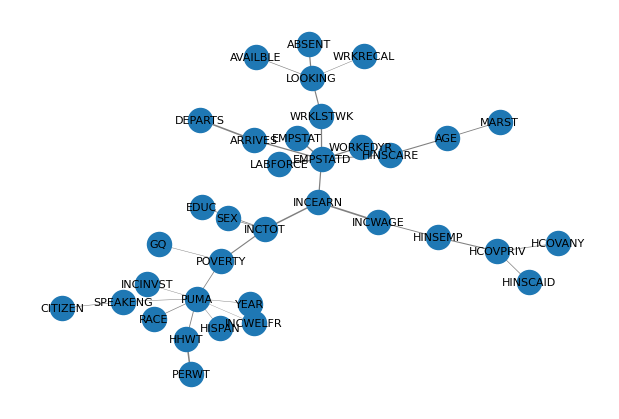

In [7]:
plt.figure(dpi=100)
pos = graphviz_layout(graph, prog="neato")
width = [w ** .5 * .003 for w in nx.get_edge_attributes(graph, "weight").values()]
nx.draw(graph, pos=pos, with_labels=True, font_size=8, width=width, edge_color="grey")

In [8]:
# Step 2

measurements_2 = [] 

for i, j in graph.edges:
    y = data.project([i, j]).datavector()
    y += np.random.normal(scale=sigma, size=y.size)
    
    measurements_2.append((np.eye(y.size), y, sigma, (i, j)))
    
model = engine.estimate(measurements_1 + measurements_2, engine="MD")

Total clique size: 34234
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		212967.95		49990107.75		0.00
50.00		5.90		63995.64		884823.73		0.00
100.00		13.55		49242.30		308068.88		0.00
150.00		21.19		43896.49		186526.22		0.00
200.00		29.06		40848.17		131835.94		0.00
250.00		36.67		38871.86		100987.97		0.00
300.00		45.18		37419.72		81512.79		0.00
350.00		53.69		36241.84		67954.61		0.00
400.00		61.63		35326.58		58597.01		0.00
450.00		70.37		34524.29		51390.81		0.00
500.00		78.76		33863.88		46000.76		0.00
550.00		93.82		33295.41		41773.42		0.00
600.00		103.89		32804.28		38399.02		0.00
650.00		111.98		32370.04		35658.83		0.00
700.00		119.59		31993.86		33413.24		0.00
750.00		127.12		31649.82		31524.05		0.00
800.00		135.21		31341.75		29937.51		0.00
850.00		143.25		31064.36		28592.97		0.00
900.00		151.37		30799.75		27412.58		0.00
950.00		158.78		30566.23		26404.30		0.00


In [9]:
synthetic_bin = model.synthetic_data(rows=len(private)).df
synthetic_bin

,PUMA,YEAR,HHWT,GQ,PERWT,SEX,AGE,MARST,RACE,HISPAN,...,WRKRECAL,WORKEDYR,INCTOT,INCWAGE,INCWELFR,INCINVST,INCEARN,POVERTY,DEPARTS,ARRIVES
0,5,6,4,1,4,0,3,5,0,0,...,3,3,5,1,1,1,1,11,35,27
1,149,1,4,1,5,1,13,0,0,0,...,3,2,1,1,1,1,1,22,1,1
2,34,5,4,1,5,1,8,0,0,0,...,3,3,7,7,1,1,7,20,21,22
3,149,3,5,1,10,1,12,4,0,0,...,3,1,4,1,1,1,1,6,1,1
4,105,3,4,1,4,1,10,0,0,0,...,3,1,5,1,1,1,1,26,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,89,4,4,1,5,1,1,5,0,0,...,3,3,2,1,1,15,1,4,1,1
99996,120,5,3,1,3,0,1,5,0,1,...,3,3,5,7,1,1,7,9,27,27
99997,123,5,8,1,4,0,3,0,0,0,...,3,3,8,11,1,1,8,20,28,24
99998,174,2,4,1,4,1,2,0,0,0,...,3,3,6,1,1,1,20,26,48,78


In [10]:
synthetic = sdnist.utils.undo_discretize(synthetic_bin, schema, sdnist.kmarginal.CensusKMarginalScore.BINS)
score = sdnist.score(private, synthetic, schema)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.90it/s]


Text(0.5, 1.0, 'Score distribution over (PUMA,YEAR)')

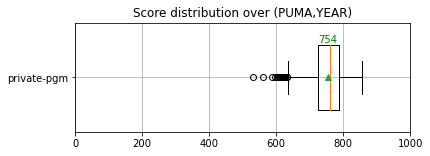

In [14]:
plt.figure(figsize=(6, 2))
score.boxplot(name="private-pgm")
plt.title(f"Score distribution over (PUMA,YEAR)")